In [290]:
import numpy as np
import math
import sys
import time

from itertools import product

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import StandardScaler

# progress bar
# from tqdm.notebook import tqdm
from tqdm import tqdm, trange

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# midi file creation
from mingus.containers import Note
from mingus.midi import fluidsynth
from mingus.containers import Bar, Track, Composition
from mingus.midi import midi_file_out

# np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4, suppress=True,linewidth=np.nan)
# torch.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(precision=4, sci_mode=False)

In [291]:
# gpu if available (global variable for convenience)
device = torch.device("cpu")
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Bach unfinished fugue 
**This project was one of the project suggestions for a course at my university (University of Groningen). I worked on the project with my teammates, but did not get (for me) satisfactory results, partly due to time constraints. We originally used a simple LSTM model (single small layer, implemented in tensorflow). I wanted to do it differently and started from scratch using PyTorch. All code in this repository folder is written by me. The description of the project is as follows:**
 
Long time ago (1993) there was a time series prediction competition organized by the Santa Fe
Institute which became rather famous in the community. The 6 data sets used for that competition have entered
the folklore of the time series prediction community. Among the data sets, the last – and by far most difficult one
– is an unfinished fugue written by Bach. The task was to use machine learning to complete the composition of
this fugue. Achieving that would amount to finishing a genius' work… In retrospect, one can marvel at the
audacity and innocence of the competition organizers; this task is of an unfathomable difficulty and far from
being solved even today. But it is fun to try one's best and see what piece of artificial music art one can get with
the machine learning tools that one masters. 

The unfinished fugue in question: ***Contrapunctus XIV: https://www.youtube.com/watch?v=JbM3VTIvOBk***

An original source paper: ***santa_fe_competition.pdf***

## Data:
Given is a text file (input.txt) which consist of 4 sequences of integer numbers representing the 4 different voices of the fugue (voices = individual parts of the music piece played simultaniously). The integer numbers represent the pitch of the voice at that current point in time. When the pitch stays the same for multiple steps in time for a single voice, the pitch is supposed to be played for the entire duration. Every timestep is 1/16th of a bar.

example (step 1251-1266):

61	55	52	47 <br>
61	55	52	47 <br>
61	55	49	47 <br>
61	55	49	47 <br>
61	55	49	47 <br>
61	55	49	47 <br>
73	54	54	46 <br>
73	54	54	46 <br>
73	54	54	46 <br>
73	54	54	46 <br>
73	54	52	46 <br>
73	54	52	46 <br>
73	54	52	46 <br>
73	54	52	46 <br>
66	54	52	47 <br>
66	54	52	47 <br>

## Evaluation
The train test split was configure as follows: the first 90 percent of the dataset was used as training data, while the last (which follows the train data) 10 percent was used as test data.  
The data was standardized, making sure no information leaks occured. The scaler was fit on the train data and used to scale both the test and train data. Additionally, the sliding window input data which leaked time information from the train set into the test set were removed.

We found the dataset to be too small, with the test data being not representative of the train data (features learned in train data did not generalize well to test data), resulting in models extracted using early stopping not generating good results.

The lowest test losses occured quickly after the start of training, meaning the models overfit quickly. Even when using really small models (~8/16 hidden units, 1/2 conv layers with 8 channels, subsential dropouts) the models quickly overfit. Larger models sometimes achieved even lower test loss, but overfit thereafter quickly. It seemed that the current configuration of test/train split was not working as well as I would have liked. 

The next step I took was making a models with a large sliding window of 80 notes, and playing around with a large double LSTM layers of 128 and 256 units. My thought process was, as I couldn't rely as well on the test loss as I would've liked, I would train a substentially sized network (to prevent underspecification) and keep the complexity in check using dropout and weight decay/l2 regularization. 

I also found a paper of which the experimental results find that the number of parameters is not a good indication of whether a model will overfit: 

<span style="color:yellow"> *"Zhang, C., Bengio, S., Hardt, M., Recht, B., & Vinyals, O. (2016). Understanding deep learning requires rethinking generalization. ArXiv. https://arxiv.org/abs/1611.03530"* </span>

regularization was tuned by choosing different amounts of dropout frequency between the LSTM layers and different weight decay parameter values. Additionally, dropout between the convolutional layers was added. This convolutional dropout was not tuned (kept at 0.1) and based on the paper: 

<span style="color:yellow"> *"Park, S., Kwak, N. (2017). Analysis on the Dropout Effect in Convolutional Neural Networks. In: Lai, SH., Lepetit, V., Nishino, K., Sato, Y. (eds) Computer Vision – ACCV 2016. ACCV 2016. Lecture Notes in Computer Science(), vol 10112. Springer, Cham. https://doi.org/10.1007/978-3-319-54184-6_12"* </span>

Subsequently, I subjectively judging the generated music by listening to it. Mostly, I listened paid attention to the point where the model continued where bach left off, before it could fall back into patterns it had learned, so to judge the generaliztion capacity of the model. I trained the model using google colab to a small training loss, and used this to generate bach-like music, which for the first time resulted in generated music that sounded like actual music. The outputs of different tests can be found in ***/output/...***.

## Conclusion
The dataset size and current train/test split configuration are not sufficient for good test evaluation.

The first next step I thought of in this project would be try a different train/test config. My first idea is to take samples from different time point in the dataset instead of all at the end as the last part of the fugue is too different from the rest. A problem with this however, is that we need to prevent time leaks, and therefore, can't use the all the samples which have some of the notes of all those time windows taken for the test set. For example, if we have a sliding window of 80 time steps, which we use to predict the time step after that, we can't use any of the previous 79 sliding windows of a sliding window (sample) in the test set. All these 80 windows, which can be used to predict any of the time steps in this 80 time step window, will have to be removed. As the dataset is already small, this does not seem to be the best idea. 

Therefore, the logical next step making a well generalizing bach music generation model would be to find a different bigger dataset, which could be used to really learn patterns in the music that translate well to a test set. My solution to this was to tune dropout and regularization untill the model was able to generate music that continued the fugue which actually sounded like music, and most importantly, a possible ending to the fugue itself. In this, I paid extra attention to the first part of the generated music (continuing from where bach ended) as this is where overfit models struggled the most. The most overfit models (low dropout, low regularization) would catch itself in its mistakes later and produce decent results after sounding really bad, probably because they accidentally fall into some pattern that is in the training data and continue from here. If the model continues well where bach left off, I was content with how well it generalized (high dropout/regu models sounded worse after first part than overfit).

The goal of this project was to finish the bach fugue, and eventhough the model is overfit compared to our test set, the generated music sounds pretty good. The model starts off really well, but gets in trouble after a while. However, the parts where you can here the model struggle still sounds greatly better than the models with the lowest test loss. Probably, there are small sections which are very similar to the training music after prediction by the model, but I am not sure if I have a problem with that in this context of the Santa Fe competition. 

Additionally, good musical knowledge + postprocessing/sampling of output of the lstm wouldn't hurt.

## best ouput is **best_output.mp3**, which starts where bach left off.

# Load data

In [292]:
# load data, 4 voices of instruments
voices = np.loadtxt("input.txt")

# remove starting silence, does not promote learning
# data shape is (3816, 4) after
voices = np.delete(voices, slice(8), axis=0)
print("Data shape (4 voices):", voices.shape)
print(voices[1242:1258])

Data shape (4 voices): (3804, 4)
[[61. 55. 52. 47.]
 [61. 55. 52. 47.]
 [61. 55. 49. 47.]
 [61. 55. 49. 47.]
 [61. 55. 49. 47.]
 [61. 55. 49. 47.]
 [73. 54. 54. 46.]
 [73. 54. 54. 46.]
 [73. 54. 54. 46.]
 [73. 54. 54. 46.]
 [73. 54. 52. 46.]
 [73. 54. 52. 46.]
 [73. 54. 52. 46.]
 [73. 54. 52. 46.]
 [66. 54. 52. 47.]
 [66. 54. 52. 47.]]


## Creating custom dataset
### First, a one hot encode function for the target values, with an function that returns the location of the value in the set of uniques.'
The target values are a one hot encoding of each voice target value, concatenated after each other. The loss is calculated with BCEWithLogitsLoss() which is often used for multi-label classification.

In [293]:
# to find float index in unique float list of standard scaled array
# works also for ints when not scaled
def uniqueLocation(uniques, note):
    for index, unique in enumerate(uniques):
        if (math.isclose(unique, note, abs_tol=0.0001)):
            return index
    return None

In [294]:
# returns concatenated onehot encoding for each note 
def one_hot_encode(y: np.ndarray, voices: np.ndarray) -> np.ndarray:
    # unique set of notes in the voice
    unique_voice1 = np.unique(voices[:,0])
    unique_voice2 = np.unique(voices[:,1])
    unique_voice3 = np.unique(voices[:,2])
    unique_voice4 = np.unique(voices[:,3])
    total = len(unique_voice1) + len(unique_voice2) + len(unique_voice3) + len(unique_voice4)

    # initialize return array
    encoded = np.zeros((y.shape[0], total), dtype=np.float32)
    
    # one hot encode each note
    for timestep, notes in enumerate(y):
        for voice, note in enumerate(notes):
            if (voice == 0):
                # get location in uniques of current note
                one_hot_location = uniqueLocation(unique_voice1, note)
                encoded[timestep][one_hot_location] = 1
            elif (voice == 1):
                one_hot_location = uniqueLocation(unique_voice2, note)
                encoded[timestep][one_hot_location + len(unique_voice1)] = 1
            elif (voice == 2):
                one_hot_location = uniqueLocation(unique_voice3, note)
                encoded[timestep][one_hot_location + len(unique_voice1) + len(unique_voice2)] = 1
            elif (voice == 3):
                one_hot_location = uniqueLocation(unique_voice4, note)
                encoded[timestep][one_hot_location + len(unique_voice1) + len(unique_voice2) + len(unique_voice3)] = 1

    return encoded

### Custom dataset consisting of a window of notes, and target values of concatenated one hot encoded vectors of the voices

In [295]:
# set_voices and all_voices used when creating a subset of all data for the current dataset (train/test)
# necessary for one-hot encoding of test data
class NotesDataset(Dataset):
    def __init__(self, window_size: int, subset_voices:np.ndarray, all_voices: np.ndarray):
        # nr of samples, and nr of voices
        self.nr_samples = subset_voices.shape[0] - window_size
        self.nr_voices = subset_voices.shape[1]

        # initialize x data -> window_size amount of notes of 4 voices each per prediction
        self.x = np.zeros((self.nr_samples, window_size, self.nr_voices), dtype=np.float32)
        for i in range(self.x.shape[0]):
            self.x[i] = subset_voices[i : i + window_size]

        # initialize y data -> 4 following target notes per time window 
        self.y = np.zeros((self.nr_samples, self.nr_voices), dtype = np.float32)
        for j in range(self.y.shape[0]):
            self.y[j] = subset_voices[j + window_size]

        # one hot encode target tensor
        self.y = one_hot_encode(self.y, all_voices)

        # create tensors
        self.x = torch.from_numpy(self.x).to(device)
        self.y = torch.from_numpy(self.y).to(device)

    def __getitem__(self, index: int):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.nr_samples

### Function to create the test and train dataloader from the custom dataset

In [296]:
# create train and test dataset based on window size where one window of timesteps
#   will predict the subsequential single timestep
# Data is created without any information leak between test/train (either scaling leak or time leak)
def createTrainTestDataloaders(voices, split_size, window_size, batch_size):
    # Train/test split
    dataset_size = len(voices[:,])
    indices = list(range(dataset_size))
    split = int(np.floor((1 - split_size) * dataset_size))
    train_indices, test_indices = indices[:split], indices[split:]

    # create split in data
    train_voices = voices[train_indices, :]
    test_voices = voices[test_indices, :]
    
    # scale both sets, using training data as fit (no leaks)
    scaler = StandardScaler()
    scaler.fit(train_voices)
    train_voices = scaler.transform(train_voices)
    all_voices = scaler.transform(voices)
    
    # create train dataset
    train_dataset = NotesDataset(window_size, train_voices, all_voices)

    # create train dataloader
    train_loader = DataLoader(train_dataset, batch_size)

    # Do the same for test set 
    if (split_size > 0):
        # scale test set
        test_voices = scaler.transform(test_voices)
        # create test dataset
        test_dataset = NotesDataset(window_size, test_voices, all_voices)
        # create test dataloader
        test_loader = DataLoader(test_dataset, batch_size)
    else:
        test_loader = None
    
    return train_loader, test_loader

# Model definition
The model consists of 3 convolutional layers followed by a double LSTM layer. Dropout frequency has been tuned for best results, along with weight decay (L2 regularization) to keep the model from becoming too complex while still learning meaningful patterns in the limited data.

In [297]:
# LSTM model with three conv layers
# The model can be set to stateful, meaning the internal hidden state and cell state is passed
#   into the model each batch and reset once per epoch.
class LSTM_model(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, batch_size, channels):
        super(LSTM_model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv_channels = channels

        # ReLU activation function
        self.relu = nn.ReLU()

        # conv dropout layer based on "Park, S., Kwak, N. (2017). Analysis on the Dropout Effect in Convolutional Neural Networks. 
        #                              In: Lai, SH., Lepetit, V., Nishino, K., Sato, Y. (eds) Computer Vision – ACCV 2016. ACCV 2016. 
        #                              Lecture Notes in Computer Science(), vol 10112. Springer, Cham. https://doi.org/10.1007/978-3-319-54184-6_12"
        self.conv_dropout = nn.Dropout(0.1) 

        # first conv layer
        padding = 1
        kernel_conv2d = 2
        c_out = channels
        lstm_input_size = input_size - kernel_conv2d + (2 * padding) + 1
        self.conv2d_1 = nn.Conv2d(1, c_out, kernel_size = kernel_conv2d, padding = padding)

        # # second conv layer
        padding = 1
        kernel_conv2d += 1
        c_out2 = c_out * 2
        lstm_input_size = lstm_input_size - kernel_conv2d + (2 * padding) + 1
        self.conv2d_2 = nn.Conv2d(c_out, c_out2, kernel_size = kernel_conv2d, padding = padding)

        # third conv layer
        padding = 1
        kernel_conv2d += 1
        c_out3 = c_out2 * 2
        lstm_input_size = lstm_input_size - kernel_conv2d + (2 * padding) + 1
        self.conv2d_3 = nn.Conv2d(c_out2, c_out3, kernel_size = kernel_conv2d, padding = padding)

        self.lstm = nn.LSTM(c_out3 * lstm_input_size, hidden_size, num_layers, dropout=0.2, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

        print("LSTM initialized with {} input size, {} hidden layer size, {} number of LSTM layers, and an output size of {}".format(input_size, hidden_size, num_layers, output_size))
        # reset states in case of stateless use
        self.reset_states(batch_size)

    # reset hidden state and cell state, should be before each new sequence
    #   In our problem: every epoch, as it is one long sequence
    def reset_states(self, batch_size):
    # def reset_states(self):
        # hidden state and cell state for LSTM 
        self.hn = torch.zeros(self.num_layers,  batch_size, self.hidden_size).to(device)
        self.cn = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

    def forward(self, input, stateful):
        # conv layer wont take it right now as it seems to have batch_size number of channels 
        # [batch_size,window_size,4]->[batch_size,1,window_size,4]
        input = input.unsqueeze(1)

        # pass through first conv layer
        out = self.conv2d_1(input)
        out = self.relu(out)

        # dropout
        out = self.conv_dropout(out)

        # pass through second conv layer
        out = self.conv2d_2(out)
        out = self.relu(out)
        
        # dropout
        out = self.conv_dropout(out)

        # pass through third conv layer
        out = self.conv2d_3(out)
        out = self.relu(out)

        # reshape for the lstm
        out = out.view(input.size(0), out.size(2), -1)

        # simple forward function
        # stateful = keep hidden states entire sequence length
        if stateful:
            # for last batch which might not be the same shape
            if (input.size(0) != self.hn.size(1)):
                self.reset_states(input.size(0))
              
            # lstm layer
            out, (self.hn, self.cn) = self.lstm(out, (self.hn.detach(), self.cn.detach())) 
            # linear output layer
            out = self.linear(out[:,-1,:])
        else:
            # initiaze hidden and cell states
            hn = torch.zeros(self.num_layers,  input.size(0), self.hidden_size).to(device)
            cn = torch.zeros(self.num_layers, input.size(0), self.hidden_size).to(device)
            # lstm layer
            out, (hn, cn) = self.lstm(out, (hn, cn))
            # linear output layer
            out = self.linear(out[:,-1,:])

        return out

# Training loop

In [298]:
def training(model, train_loader:DataLoader, test_loader:DataLoader, nr_epochs, optimizer, loss_func, scheduler, stateful, writer):
    # lowest train/test loss, train/test loss lists
    lowest_train_loss = np.inf
    lowest_test_loss = np.inf
    train_losses = []
    test_losses = []

    # test_loss declaration untill assigned in model evaluation (used in progress bar print)
    test_loss = "n/a"

    # training loop
    for epoch in (progress_bar := tqdm(range(1, nr_epochs))):
        # add epoch info to progress bar
        progress_bar.set_description(f"Epoch {epoch}")

        # reset lstm hidden and cell state (stateful lstm = reset states once per sequence)
        # if not, reset automatically each forward call
        if stateful:
            model.reset_states(train_loader.batch_size)

        # reset running loss
        running_loss_train = 0
        running_loss_test = 0

        # train loop
        model.train()
        # tqdm = progress bar utility
        # for i, (inputs, labels) in enumerate(progress_bar := tqdm(train_loader, desc = f"Epoch {epoch}")):
        for i, (inputs, labels) in enumerate(train_loader):
            # reset gradient function of weights
            optimizer.zero_grad()
            # forward
            prediction = model(inputs, stateful)
            # calculate loss
            loss = loss_func(prediction, labels)
            # backward, retain_graph = True needed for hidden lstm states
            loss.backward(retain_graph=True)
            # step
            optimizer.step()
            # add to running loss
            running_loss_train += loss.item()

        # learning rate scheduler step
        scheduler.step()

        # calc running loss
        train_loss = running_loss_train/len(train_loader)
        train_losses.append(train_loss)

        # add loss to tensorboard
        writer.add_scalar("Running train loss", train_loss, epoch)        

        # check if lowest loss
        if (train_loss < lowest_train_loss):
            lowest_train_loss = train_loss
            # Save model
            torch.save(model.state_dict(), "models/model" + str(train_loader.dataset.x.shape[1]) + str(model.hidden_size) + str(model.conv_channels) + ".pth")

        # Test evaluation
        if (test_loader):
            # model.eval()
            with torch.no_grad():
                for j, (inputs, labels) in enumerate(test_loader):
                    # forward pass
                    prediction = model(inputs, stateful)
                    # calculate loss
                    test_loss = loss_func(prediction, labels)
                    # add to running loss

            # calc running loss
            test_loss = running_loss_test/len(test_loader)
            test_losses.append(test_loss)

            # add test loss to tensorboard
            writer.add_scalar("Running test loss", test_loss, epoch)

            # if lowest till now, save model (checkpointing)
            if (test_loss < lowest_test_loss):
                lowest_test_loss = test_loss
                torch.save(model.state_dict(), "models/model" + str(train_loader.dataset.x.shape[1]) + str(model.hidden_size) + str(model.conv_channels) + "test" + ".pth")

        # before next epoch: add last epoch info to progress bar
        progress_bar.set_postfix({"train_loss": train_loss, "test_loss": test_loss})

    # save hparams along with lowest train/test losses
    writer.add_hparams(
        {"window_size": train_loader.dataset.x.shape[1], "hidden_size": model.hidden_size, "conv_channels": model.conv_channels},
        {"MinTrainLoss": lowest_train_loss, "MinTestLoss": lowest_test_loss},
    )

    return train_losses, test_losses

## Hyperparamers
The hyperparameters dictionary acts as a grid search if multiple values for the parameters are given.

In [299]:
# batch_size for training network
batch_size = 16

# split size of test/train data
split_size = 0.0

# hyperparameters for fine-tuning
    # window_size = sliding window on time-sequence data for input
    # hidden_size = hidden units of lstm layer(s)
    # conv_channels = number of channels in the first conv layer (multiplied by 2 every next layer)
    # nr_layers = number of lstm layers stacked after each other
hyperparams = dict(
    window_size = [80],
    hidden_size = [256],
    conv_channels = [8],
    nr_layers = [2]
)
# sets of combinations of hparams
hyperparam_value_sets = product(*[value for value in hyperparams.values()])

## Grid search loop
### Lowest test loss (early stopping) and lowest train loss models get saved to *models/* under naming based on the hyperparameters.
Tensorboard is used to see loss curves.

In [300]:
# Loop through different combinations of the hyperparameters
for run_id, (window_size, hidden_size, conv_channels, nr_layers) in enumerate(hyperparam_value_sets):
    # tensorboard summary writer
    writer = SummaryWriter(f'runs/window_size={window_size} hidden_size={hidden_size} conv_channels={conv_channels}')
    
    # Split data in train and test, scale, create datasets and create dataloaders
    train_loader, test_loader = createTrainTestDataloaders(voices, split_size, window_size, batch_size)

    # some informational print statements
    print("\nNew run window/hidden/channels/batch_size:", window_size, "/", hidden_size, "/", conv_channels, "/", batch_size)
    features, labels = next(iter(train_loader))
    print("Input size:", features.size(), 
        "- Output size:", labels.size(), 
        "- TRAIN batches:", len(train_loader), 
        "- TEST batches:", len(test_loader) if test_loader else "Not available")
    # Input/output dimensions
    input_size = voices.shape[1]
    output_size = labels.size(1)

    # create model
    lstm_model = LSTM_model(input_size, output_size, hidden_size, nr_layers, batch_size, conv_channels)

    # loss function and optimizer
    #   multi lable one hot encoded prediction only works with BCEwithlogitloss
    loss_func = nn.BCEWithLogitsLoss()
    # AdamW = Adam with fixed weight decay (weight decay performed after controlling parameter-wise step size)
    optimizer = optim.AdamW(lstm_model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=750)
    
    # to gpu if possible
    lstm_model = lstm_model.to(device)
    
    # training loop
    epochs = 1000
    # In this example we should not use a stateful lstm, as the next samples (subsequent sliding windows) do not follow directly from the current.
    # This is only the case when the first sample is (for Ex.) [1:10] which is the first window, and [11:20] the next, and so on.
    # With our data it would be: [1:10] and the next [2:11]. Target value does not matter necessarily. 
    # More explanation: https://stackoverflow.com/questions/58276337/proper-way-to-feed-time-series-data-to-stateful-lstm
    #   unfortunately I implemented stateful before knowing these in and outs.
    stateful = False
    train_losses, test_losses = training(lstm_model, train_loader, test_loader, epochs, optimizer, loss_func, scheduler, stateful, writer)

    # flush tensorboard writer
    writer.flush()

Epoch 1:   0%|          | 0/999 [00:00<?, ?it/s]


New run window/hidden/channels/batch_size: 48 / 16 / 8 / 16
Input size: torch.Size([16, 48, 4]) - Output size: torch.Size([16, 98]) - TRAIN batches: 235 - TEST batches: Not available
LSTM initialized with 4 input size, 16 hidden layer size, 2 number of LSTM layers, and an output size of 98


Epoch 999: 100%|██████████| 999/999 [3:08:34<00:00, 11.33s/it, train_loss=0.0699, test_loss=n/a]  


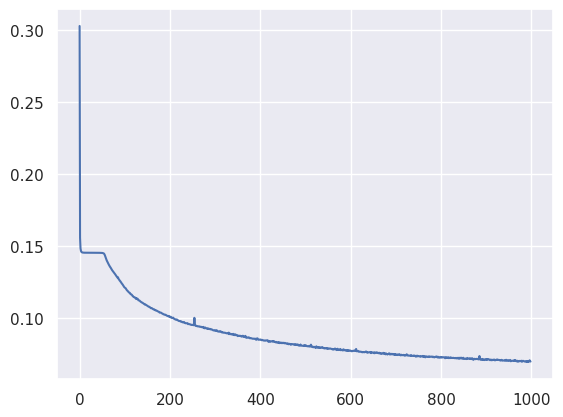

In [301]:
# quick plots
sns.lineplot(train_losses)
sns.lineplot(test_losses)
plt.show()

# Generate music using one of the models

### Function to predict x next notes

In [302]:
def predictNextNotes(input, steps, lstm_model, voices, scaler):
    # predicted notes
    predicted_notes = np.zeros((1,4))

    # all unique notes for each voice
    unique_voice1 = np.unique(voices[:,0])
    unique_voice2 = np.unique(voices[:,1])
    unique_voice3 = np.unique(voices[:,2])
    unique_voice4 = np.unique(voices[:,3])
    one_hot_values = np.concatenate((unique_voice1, unique_voice2, unique_voice3, unique_voice4))

    # BCEwithLogitLoss uses sigmoid when calculating loss, but we need to pass through
    sigmoid = nn.Sigmoid()

    # prepare input
    input = torch.tensor(input, dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        for i in range(steps):
            # print(input.shape)
            output = lstm_model(input, stateful=False)
            output = sigmoid(output)
            # print(output)
            output = output.detach().numpy().squeeze()

            # get the indices with highest value from model forward output
            note_voice1 = np.argmax(output[:len(unique_voice1)])
            note_voice2 = np.argmax(output[len(unique_voice1) : len(unique_voice1) + len(unique_voice2)])
            note_voice3 = np.argmax(output[len(unique_voice1) + len(unique_voice2) : len(unique_voice1) + len(unique_voice2) + len(unique_voice3)])
            note_voice4 = np.argmax(output[-len(unique_voice4):])
            # print(note_voice1, note_voice2, note_voice3, note_voice4)

            # get notes
            note_voice1 = one_hot_values[note_voice1]
            note_voice2 = one_hot_values[len(unique_voice1) + note_voice2]
            note_voice3 = one_hot_values[len(unique_voice1) + len(unique_voice2) + note_voice3]
            note_voice4 = one_hot_values[len(unique_voice1) + len(unique_voice2) + len(unique_voice3) + note_voice4]

            # add to array and inverse scale
            next_notes = np.array([note_voice1, note_voice2, note_voice3, note_voice4])
            next_notes_invscaled = scaler.inverse_transform(next_notes.reshape(1, -1))
            # print(next_notes_invscaled)
            predicted_notes = np.concatenate((predicted_notes, next_notes_invscaled), axis = 0)
            # print(predicted_notes)

            # change input
            # drop oldest notes
            input = input[0][1:]
            # concat predicted notes
            input = torch.cat((input, torch.Tensor(next_notes).unsqueeze(0)))
            input = input.unsqueeze(0)

    return(predicted_notes.astype(np.int32)[1:])

## Load model and generate new notes

In [303]:
# initialize model
# model = LSTM_model(input_size = 4, output_size = 98, hidden_size = 64, num_layers = 2, batch_size = 32, channels = 8)
# load model file
# model.load_state_dict(torch.load("models/model80648.pth", map_location=device))
model = lstm_model

# load data, 4 voices of instruments
voices = np.loadtxt("input.txt")

# Train/test split (needed for correct scaling of new data)
dataset_size = len(voices[:,])
indices = list(range(dataset_size))
split = int(np.floor((1 - split_size) * dataset_size))
train_indices = indices[:split]
# create split in data
train_voices = voices[train_indices, :]

# fit the scaler to the train data
scaler = StandardScaler()
scaler.fit(train_voices)
# scale voices
voices = scaler.transform(voices)
train_voices = scaler.transform(train_voices)

# take last sliding window in data and infer from there
input = train_voices[-window_size:]
steps = 1500
new_music = predictNextNotes(input, steps, model, voices, scaler)

# save new music
np.savetxt(fname = "output/output.txt", X = new_music, fmt = "%d")

## Create a midi files from generated music (output and complete fugue)

In [304]:
# initialize fluidsynth with soundfont
fluidsynth.init("soundfonts/040_Florestan_String_Quartet.sf2", "salsa")

# load original music
original = np.loadtxt("input.txt")

# load network output music
output = np.loadtxt("output/output.txt")

# concatenate
complete = np.concatenate((original, output), axis = 0)

# create midi for output and comlete (original + output)
for run, voices in enumerate([output, complete]):
    # create 4 tracks for the 4 voices
    encoded_voices = [Track(), Track(), Track(), Track()] 
    
    # loop through the generated voices
    for i, notes in enumerate([voices[:,0], voices[:,1], voices[:,2], voices[:,3]]):
        # initialize as impossible note
        last_note = -1
        count = 1
        for j, note in enumerate(notes):
            if note:
                if ((note == last_note) or (j == 0)):
                    # same note as previous note
                    count += 1
                    last_note = note
                    
                    if (j + count > len(notes)):
                        # current note reaches end of file
                        n = Note()
                        n.from_int(int(last_note))
                        b = Bar()
                        b.place_notes(n, 16/count)
                        encoded_voices[i].add_bar(b)
                else:
                    # different note encountered
                    # add previous note with its duration to track
                    n = Note()
                    n.from_int(int(last_note))
                    b = Bar()
                    
                    # 8 should be 1/2 -> 2
                    # 16 should be 1 -> 1
                    # 32 should be 2 -> 0.5
                    b.place_notes(n, duration = 16/count)
                    encoded_voices[i].add_bar(b)
                    
                    # reset
                    count = 1
                    last_note = note
            else:
                # current note = 0, means a pause (silence)
                b = Bar()
                b.place_rest(16)
                encoded_voices[i].add_bar(b)

    output_composition = Composition()
    output_composition.add_track(encoded_voices[0])
    output_composition.add_track(encoded_voices[1])
    output_composition.add_track(encoded_voices[2])
    output_composition.add_track(encoded_voices[3])

    if (run == 0):
        midi_file_out.write_Composition("output/output.midi", output_composition)
    else:
        midi_file_out.write_Composition("output/complete.midi", output_composition)


## Create mp3
For Linux.  
windows -> remove %%bash, add !before each fluidsynth call

In [305]:
%%bash
timidity output/output.midi -Ow -o - | ffmpeg -i - -acodec libmp3lame -ab 320k output/output.mp3
timidity output/complete.midi -Ow -o - | ffmpeg -i - -acodec libmp3lame -ab 320k output/complete.mp3

Playing output/output.midi
MIDI file: output/output.midi
Format: 1  Tracks: 4  Divisions: 72
Sequence: Untitled
Track name: Untitled
Track name: Untitled
Track name: Untitled
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubbe